In [ ]:
!pip install dipy
!pip install einops

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.2/45.2 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.8/80.8 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 30.8 MB/s eta 0:00:00
  Attempting uninstall: nibabel
    Found existing installation: nibabel 4.0.2
    Uninstalling nibabel-4.0.2:
      Successfully uninstalled nibabel-4.0.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 2.3 MB/s eta 0:00:00


In [ ]:
import os
from google.colab import drive
mount_path = '/content/drive'
drive_path = mount_path+"/MyDrive/dti-transformer/code/cl-training"
results_path = drive_path+"/results/FA"
drive.mount(mount_path)
os.chdir(drive_path)
continue_training = True

Mounted at /content/drive


In [ ]:
# Daniel Bandala @ mar-2023
# dti-model training script
# general libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from random import shuffle
# diffussion image processing
from dipy.io.image import load_nifti
# import torch libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
# import dataset auxiliar libraries
from data_loader_cl import *
from tqdm.notebook import tqdm
# import model
import sys
sys.path.insert(1, '../model')
from dti_model import DiffusionTensorModel

In [ ]:
# set plot parameters
plt.rcParams.update({'font.size': 20})

In [ ]:
# folders dataset
main_dir = '/content/drive/MyDrive/dti-transformer/dti_data/INUTR'

In [ ]:
# read difussion data
data, affine = load_nifti(main_dir+'/case_02/input/DWI_opt.nii.gz')
data.shape

(112, 112, 70, 15)

In [ ]:
# read difussion data
output, _ = load_nifti(main_dir+'/case_02/output/DTI_FA.nii.gz')
output.shape

(112, 112, 70)

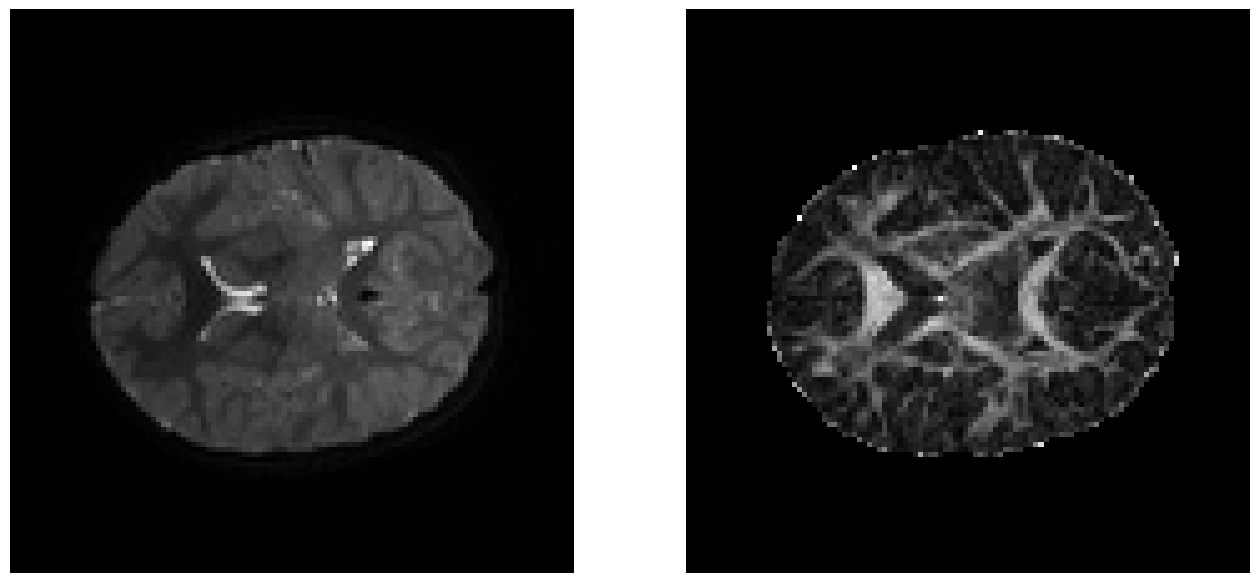

In [ ]:
plt.figure(figsize=(16,8))
plt.subplot(1, 2, 1).set_axis_off()
plt.imshow(data[:, :, 35, 0], cmap='gray', origin='lower')
plt.subplot(1, 2, 2).set_axis_off()
plt.imshow(output[:, :, 35], cmap='gray', origin='lower')

In [ ]:
# input channels
signals = 7
# define training parameters
batches = 10
epochs = 80
test_size = 0.1
start_epoch = 0
# optimizer parameters
lr = 1e-7
weight_decay = 1e-6
gamma = 0.8 #for learning rate scheduler
step_size = 1
seed = 24
# select available device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# folders dataset
main_dir = ['/content/drive/MyDrive/dti-transformer/dti_data/INUTR']

In [ ]:
# load dataset
maps = ["FA"] #"MD","MO","L1","L2","L3"
train_list, valid_list, train_loader, valid_loader = get_dataset(main_dir, test_size, batches, maps=maps, signals=signals, dti_folder='output')

Train Data: 63
Validation Data: 8


In [ ]:
# load model
model = DiffusionTensorModel(
    in_chans=signals,
    out_chans=1,
    img_size=140,
    embed_dim=64,
    n_heads=[1,2,4,8],
    mlp_ratio=[2,2,4,4],
    reduction_ratio=1,
    depth_prob=0.2,
    tanh_output=False
)
# loss function
criterion = nn.MSELoss()
# optimizer
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
# scheduler
scheduler = StepLR(optimizer, step_size=step_size, gamma=gamma)

In [ ]:
device
# copy model to gpu
_ = model.to(device)

In [ ]:
# enable training graphics widget
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
Paths used for configuration of notebook: 
    	/root/.jupyter/nbconfig/notebook.json
Paths used for configuration of notebook: 
    	
      - Validating: OK
Paths used for configuration of notebook: 
    	/root/.jupyter/nbconfig/notebook.json


In [ ]:
# model weights path
model_path = results_path+"/dti_fa.weights" if continue_training else results_path+"/../dti_fa.weights"
ch_path = results_path+"/opt.pt.tar"

In [ ]:
# load model and parameters to keep training
if continue_training:
    checkpoint = torch.load(ch_path)
    start_epoch = int(checkpoint['epoch'])
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
else:
    model.load_state_dict(torch.load(model_path))

In [ ]:
# set model on training mode
_ = model.train()
# set a uid for training (with random alphanumeric chars)
train_uid = "_cltraining-"+str(start_epoch)
# get trainable parameters
print("Trainable parameters: ", get_params(model))

Trainable parameters:  35209439


In [ ]:
#start training
ep_loss = []
# error variables
prev_error = float("inf")
#seed_everything(seed)
for epoch in range(start_epoch, epochs):
    epoch_loss = 0.
    for batch_data, batch_label in tqdm(train_loader):
        batch_range = list(range(batch_data.shape[0]))
        shuffle(batch_range)
        for i in batch_range:
            slice_data = batch_data[i].to(device)
            slice_label = batch_label[i].to(device)
            samples_t = slice_data.shape[0]
            s_counter = 0
            slice_range = list(range(samples_t))
            shuffle(slice_range)
            for s in slice_range:
                s_counter += 1
                data = slice_data[s]
                label = slice_label[s]

                # forward - evaluate model
                output = model(data)
                loss = criterion(output, label)
                # backward propagation
                loss.backward()

                # loss average
                epoch_loss += loss.item()

                #if s_counter%48==0:
            # optimize model - update network weights
            optimizer.step()
            # zero the parameter gradient
            optimizer.zero_grad()

    # calculate loss on validation set
    epoch_val_loss = 0
    with torch.no_grad():
        for batch_data, batch_label in valid_loader:
            for i in range(batch_data.shape[0]):
                slice_data = batch_data[i].to(device)
                slice_label = batch_label[i].to(device)
                samples_v = slice_data.shape[0]
                for s in range(samples_v):
                    data = slice_data[s]
                    label = slice_label[s]
                    # evaluate model on validation case
                    val_output = model(data)
                    val_loss = criterion(val_output, label)
                    # validation loss
                    epoch_val_loss += val_loss.item()

    # append to epoch array
    epoch_loss = epoch_loss/(len(train_list)*samples_t)
    epoch_val_loss = epoch_val_loss/(len(valid_list)*samples_v)
    ep_loss.append([epoch_loss,epoch_val_loss])
    # adjust learning rate in case the error did not decrease
    if prev_error<epoch_loss:
        scheduler.step()
    # assign epoch loss to next comparisson
    prev_error = epoch_loss
    # save error list
    try:
        pd.DataFrame(ep_loss).to_csv(results_path+"/training_loss"+train_uid+".csv",index=False, header=False)
    except Exception as e:
        print("Error saving loss data")
        drive.mount(mount_path, force_remount=True)
        os.chdir(drive_path)
    # save model weights and training parameters
    try:
        torch.save({'epoch': epoch+1,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'scheduler_state_dict': scheduler.state_dict()
                    }, ch_path)
    except Exception as e:
        print("Error saving model: ", e)
        drive.mount(mount_path, force_remount=True)
        os.chdir(drive_path)
    # print epoch metrics
    print(
        f"Epoch: {epoch+1}  -  train loss: {epoch_loss:.8f}  -  valid loss: {epoch_val_loss:.8f} \n"
    )
# return model to cpu
_ = model.to("cpu")
# save final model
torch.save(model.state_dict(), model_path)
# complete
print("\nTraining finished")

  0%|          | 0/11 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch: 79  -  train loss: 0.00160086  -  valid loss: 0.00147843 



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 80  -  train loss: 0.00159474  -  valid loss: 0.00147956 


Training finished


In [ ]:
# evaluate model
data, label = data_preprocessing(valid_list[0], maps=maps, signals=signals, dti_folder='output')
data_val, label_val = data[35], label[35]

In [ ]:
_ = model.to("cpu")
model.eval()
with torch.no_grad():
    output = model(data_val)

In [ ]:
print("Data: ",data.shape)
print("Label: ",label.shape)
print("Data to evaluate: ",data_val.shape)
print("Label to evaluate: ",label_val.shape)
print("Output: ",output.shape)

Data:  torch.Size([96, 7, 140, 140])
Label:  torch.Size([96, 140, 140])
Data to evaluate:  torch.Size([7, 140, 140])
Label to evaluate:  torch.Size([140, 140])
Output:  torch.Size([140, 140])


In [ ]:
# detach data
data_eval_np = data_val.detach().numpy()
label_eval_np = label_val.detach().numpy()
output_eval_np = output.detach().numpy()

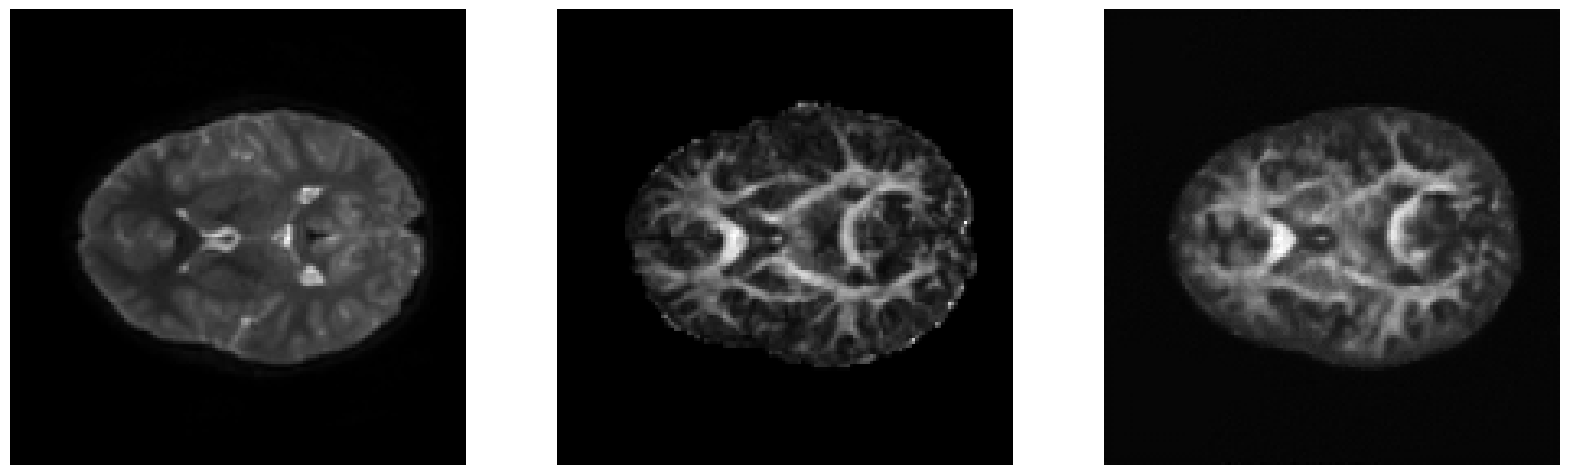

In [ ]:
# print visual evaluation
plt.figure(figsize=(20,12))
plt.subplot(1, 3, 1).set_axis_off()
plt.imshow(data_eval_np[0], cmap='gray', origin='lower')
plt.subplot(1, 3, 2).set_axis_off()
plt.imshow(label_eval_np, cmap='gray', origin='lower')
plt.subplot(1, 3, 3).set_axis_off()
plt.imshow(output_eval_np, cmap='gray', origin='lower')
plt.savefig(results_path+"/fa_result.png")

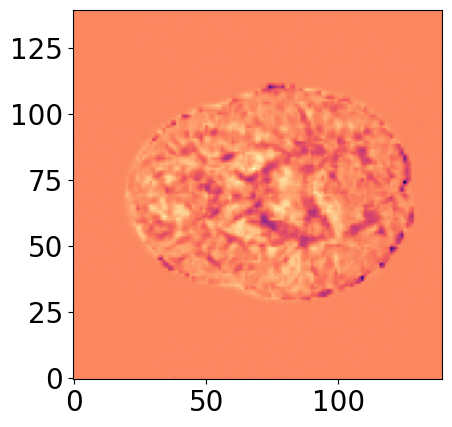

In [ ]:
res = label_eval_np-output_eval_np
plt.imshow(res, cmap='magma_r', origin='lower')